In [109]:
"""In this notebook, we explore potential risk indicators of the level of risk
associated with a loan. To do this, we calculate the default rate for specific groups and
identify the more significant causes. At the start of the notebook, we define some functions
for data visualisation."""

'In this notebook, we explore potential risk indicators of the level of risk\nassociated with a loan. To do this, we calculate the default rate for specific groups and\nidentify the more significant causes. At the start of the notebook, we define some functions\nfor data visualisation.'

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

In [111]:
df = pd.read_csv('SBAnational_cleaned.csv', dtype={'ApprovalDate': str, 'DisbursementDate': str},
                 parse_dates=['ApprovalDate', 'DisbursementDate'], sep=',')

print(df.head(15))
print(df.dtypes)
print(df.columns)

    LoanNr_ChkDgt                            Name            City State  \
0      1000014003                  ABC HOBBYCRAFT      EVANSVILLE    IN   
1      1000024006     LANDMARK BAR & GRILLE (THE)       NEW PARIS    IN   
2      1000034009           WHITLOCK DDS, TODD M.     BLOOMINGTON    IN   
3      1000044001   BIG BUCKS PAWN & JEWELRY, LLC    BROKEN ARROW    OK   
4      1000054004     ANASTASIA CONFECTIONS, INC.         ORLANDO    FL   
5      1000084002  B&T SCREW MACHINE COMPANY, INC      PLAINVILLE    CT   
6      1000093009   MIDDLE ATLANTIC SPORTS CO INC           UNION    NJ   
7      1000094005                 WEAVER PRODUCTS     SUMMERFIELD    FL   
8      1000104006                TURTLE BEACH INN  PORT SAINT JOE    FL   
9      1000124001         INTEXT BUILDING SYS LLC     GLASTONBURY    CT   
10     1000134004  COMMERCIAL TRUCKING MAINTENANC       CHARLOTTE    NC   
11     1000144007  PROFESSIONAL ELEVATOR SERVICES         CHICAGO    IL   
12     1000146010        

In [112]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 45)

In [113]:
## We first define data visualisation functions (they will make sense later) ##

In [114]:
# Building a function to visualise state analysis
def state_visualisation(df2, variable, factor=1, title='', annotation='', colourmap='RdYlGn'):
    # Getting appropriate geodataframe
    import geopandas as gpd
    map_df = gpd.read_file('states.shp')

    # Reformatting geodataframe to match loan data
    us_state_to_abbrev = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
                          "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA",
                          "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
                          "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
                          "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
                          "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
                          "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
                          "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR",
                          "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
                          "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA",
                          "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY",
                          "District of Columbia": ""}
    map_df.STATE_NAME = map_df.STATE_NAME.replace(us_state_to_abbrev)

    plt.rcParams['figure.figsize'] = [5, 5]

    # Merging input dataframe with map geodataframe
    col_name = df2.columns.values.tolist()[0]
    merged = map_df.merge(df2, how='left', left_on="STATE_NAME", right_on=col_name)
    merged = merged[['STATE_NAME', 'geometry', variable]]
    merged.rename(columns={'STATE_NAME': 'State'})

    # Initialising plot
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
    ax.annotate(annotation, xy=(0.2, 0.5), xycoords='figure fraction', fontsize=12, color='#555555')

    # Creating colourbar and colourbar label
    v_min, v_max = 0, 38.4
    if colourmap == 'RdYlGn':
        colourmap = colormaps[colourmap]
        colourmap = colourmap.reversed()
    sm = plt.cm.ScalarMappable(cmap=colourmap, norm=plt.Normalize(vmin=v_min, vmax=v_max))
    sm.set_array([])

    if factor == 1:
        label = 'Default rate (%)'
    else:
        label = 'Number of loans (1000s)'
    fig.colorbar(sm, fraction=0.046, pad=0.04, aspect=30, label=label, ax=ax)

    merged.plot(column=variable, cmap=colourmap, linewidth=0.8, ax=ax, edgecolor='0.8')

    # Annotating with state abbreviations
    merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
    merged['coords'] = [coords[0] for coords in merged['coords']]
    for idx, row in merged.iterrows():
        plt.annotate(text=row['STATE_NAME'], xy=row['coords'], horizontalalignment='center', fontsize=6)

    plt.show()

In [115]:
# Building a function to visualise binary feature analysis.
def binary_visualisation(df2):
    def_rate_1, def_rate_2 = df2.Default_Rate_Pct[0], df2.Default_Rate_Pct[1]
    frac_1, frac_2 = [def_rate_1, 100 - def_rate_1], [def_rate_2, 100 - def_rate_2]
    labels = ['Charged off', 'Paid in full']

    colourmap = colormaps['RdYlGn']
    colours = [colourmap(0), colourmap(colourmap.N)] # 'Extreme' colours

    figure = plt.figure(figsize=(12, 4))
    figure.tight_layout()

    ax1 = figure.add_axes([0, 0, 0.5, 0.5], aspect=1)
    ax1.pie(frac_1, labels=labels, colors=colours, radius=1.2, autopct='%1.1f%%')
    ax1.set_title(str(df2.iloc[:, 0][0]))

    ax2 = figure.add_axes([0.5, 0, 0.5, 0.5], aspect=1)
    ax2.pie(frac_2, labels=labels, colors=colours, radius=1.2, autopct='%1.1f%%')
    ax2.set_title(str(df2.iloc[:, 0][1]))

    figure.suptitle('Analysis by ' + str(df2.columns.values.tolist()[0]))
    plt.show()

In [116]:
# Building a function to visualise analysis of continuous features (cut into k quartiles)
def quartile_visualisation(df2):
    tick_labels = [df2.iloc[:, 0][i] for i in range(len(df2.index))]
    x_pos = [i for i in range(len(df2.index))]
    heights = [df2.iloc[:, 2][i] for i in range(len(df2.index))]

    colourmap = colormaps['RdYlGn']
    colourmap = colourmap.reversed()
    norm = colors.Normalize(vmin=0, vmax=38.4)

    figure, axes = plt.subplots(figsize=(10, 5))

    # axes.hist(tick_labels, weight=heights, color=colourmap(norm(heights)))
    axes.bar(x_pos, heights, tick_label=tick_labels, color=colourmap(norm(heights)), width=0.99)
    axes.yaxis.set_visible(False)
    axes.set_xlabel(str(df2.columns.values.tolist()[0]))
    axes.set_title('Analysis by ' + str(df2.columns.values.tolist()[0]))

    sm = plt.cm.ScalarMappable(cmap=colourmap, norm=norm)
    sm.set_array([])
    figure.colorbar(sm, fraction=0.046, pad=0.04, label='Default Rate (%)', ax=axes)

    plt.show()

In [117]:
# Calculating total default rate
default_overall = df.groupby('MIS_Status').LoanNr_ChkDgt.count().reset_index()
default_overall.columns = ['MIS Status', 'Count']
default_rate = default_overall.Count[0] / (default_overall.Count[0] + default_overall.Count[1])
print(default_rate)  
# Around 17%


0.1757590638445098


In [118]:
# Defining a function which calculates default rate for specific groups
def default_rate_calc(colname):
    # Creating a dataframe showing number of loans per group
    final_df = df.groupby(colname).LoanNr_ChkDgt.count().reset_index()
    final_df.rename(columns={'LoanNr_ChkDgt': 'Num_Loans'}, inplace=True)

    # Creating a dataframe showing MIS_Status per group
    mis = df.groupby([colname, 'MIS_Status']).LoanNr_ChkDgt.count().unstack(fill_value=0).stack().reset_index()
    mis.columns = [colname, 'MIS_Status', 'Count']
    # Calculating default rate
    ls = []
    for j in range(int(len(mis.Count) / 2)):
        numerator = mis.Count[2 * j]
        denominator = numerator + mis.Count[2 * j + 1]

        if denominator == 0:
            ls.append(float(0))
        else:
            ls.append(100 * round(numerator / denominator, 3))

    # Adding default rates to initial dataframe
    final_df['Default_Rate_Pct'] = ls
    final_df.sort_values('Default_Rate_Pct', inplace=True, ascending=False)
    return final_df

In [119]:
# Analysis by state
by_state = default_rate_calc('State')
print(by_state)  
# Some correlation

   State  Num_Loans  Default_Rate_Pct
9     FL      41174              27.4
7     DC       1609              24.1
10    GA      22255              24.0
33    NV       7995              23.3
14    IL      29568              22.7
..   ...        ...               ...
41    SD       4424               7.9
28    ND       5232               7.7
47    VT       5423               7.4
51    WY       2834               7.0
26    MT       8727               6.8

[52 rows x 3 columns]


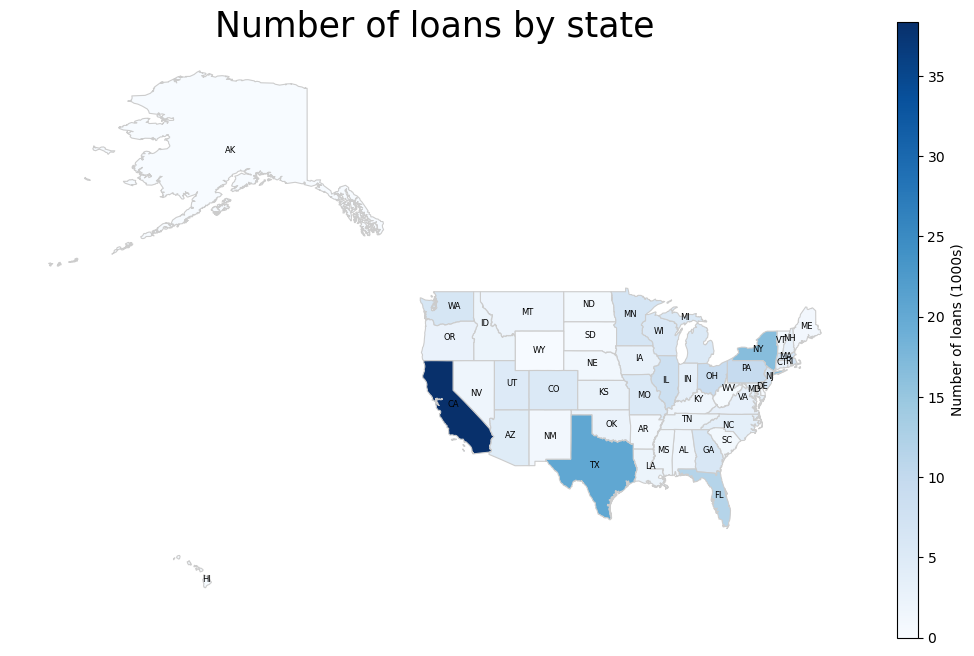

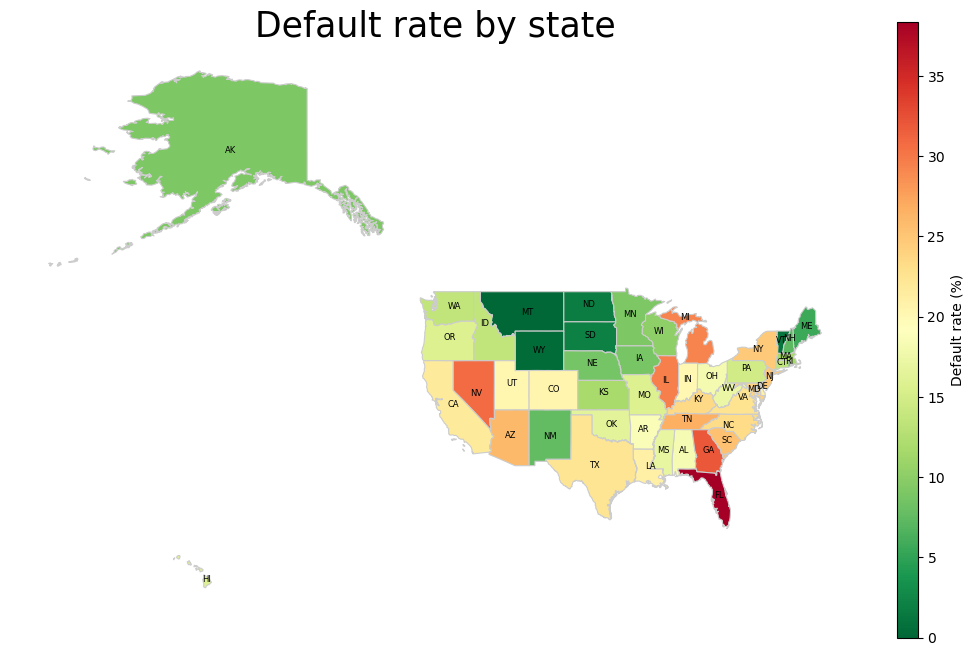

In [120]:
# Visualising above data
state_visualisation(by_state, 'Num_Loans', title='Number of loans by state', factor=1000, colourmap='Blues')
state_visualisation(by_state, 'Default_Rate_Pct', title='Default rate by state', factor=1)

In [121]:
# Analysis by bank state
bank_state = default_rate_calc('BankState')
print(bank_state)  
# Limited correlation compared to State.

   BankState  Num_Loans  Default_Rate_Pct
46        VA      28941              38.3
27        NC      79405              29.4
8         DE      24498              25.4
14        IL      65805              22.3
4         CA     117933              22.1
..       ...        ...               ...
44        UN       1673               6.3
30        NH       6786               5.5
47        VT       4745               5.5
26        MT       7838               5.4
51        WY       2163               5.0

[52 rows x 3 columns]


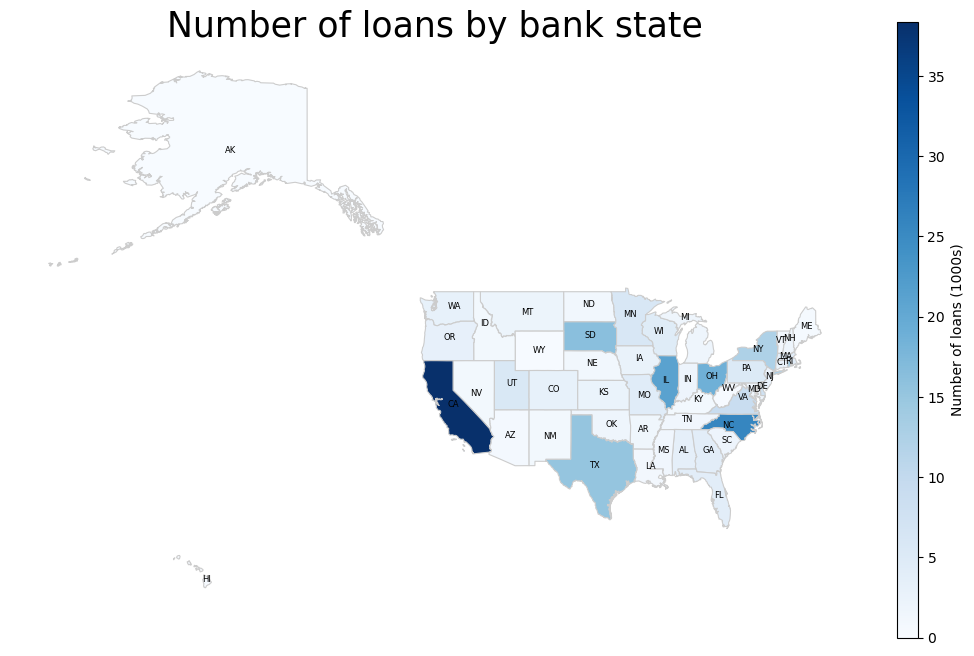

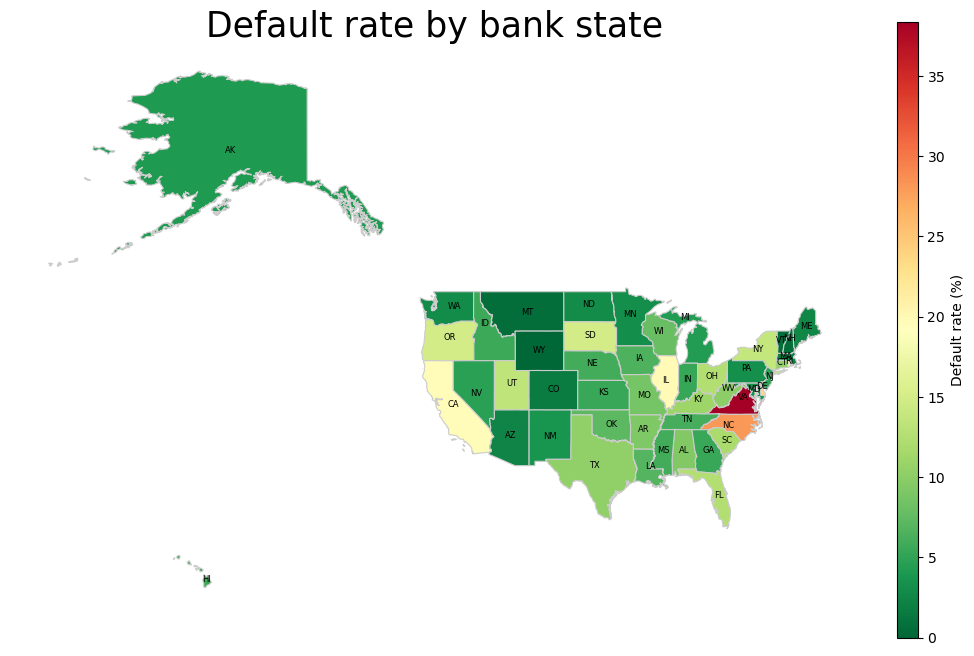

In [122]:
# Visualising the above data
state_visualisation(bank_state, 'Num_Loans', title='Number of loans by bank state', factor=1000, colourmap='Blues')
state_visualisation(bank_state, 'Default_Rate_Pct', title='Default rate by bank state', factor=1)

In [123]:
# Analysis by city
by_city = default_rate_calc('City')
print(by_city)  
# There are too many cities for this variable to be useful

                   City  Num_Loans  Default_Rate_Pct
18436         Manhatten          1             100.0
2376              BORUP          1             100.0
15878           LaPlata          1             100.0
15877            LaPine          1             100.0
15869          LaConner          1             100.0
...                 ...        ...               ...
15929         Lake Elmo          1               0.0
15928         Lake Como          1               0.0
15926      Lake Charles          2               0.0
15925  Lake Buena Vista          1               0.0
0       #115, BALTIMORE          1               0.0

[32521 rows x 3 columns]


In [124]:
# Analysis by bank
bank = default_rate_calc('Bank')
print(bank)  
# There are too many banks for this variable to be useful.

                              Bank  Num_Loans  Default_Rate_Pct
2262     FIRST COMMERCIAL MORTGAGE         15             100.0
4870        STATE BANK OF MISSOURI          1             100.0
2590   FIRST STATE BANK OF DECATUR          1             100.0
2570   FIRST ST. BK OF ST. CHARLES          1             100.0
2565   FIRST ST. BK OF DEKALB CNTY          1             100.0
...                            ...        ...               ...
3433               LUSK STATE BANK         13               0.0
864     BREMER FINAN SERVICES INC.          1               0.0
3436       LYNN CAPITAL INVESTMENT          9               0.0
3437            LYONS FEDERAL BANK          2               0.0
0     1ST & FARMERS BK HOLDING CO.          1               0.0

[5799 rows x 3 columns]


In [125]:
# Urban vs rural analysis
urb_rur = default_rate_calc('UrbanRural')
print(urb_rur)  
# Although there is some correlation, there are too many unknowns for this feature to be useful.

   UrbanRural  Num_Loans  Default_Rate_Pct
1           1     468811              24.5
2           2     104876              18.8
0           0     322318               7.1


In [126]:
# Analysis by revolving line of credit
rev_cr = default_rate_calc('RevLineCr')
print(rev_cr)  
# Although there is some correlation, there are too many unknowns for this feature to be useful.

  RevLineCr  Num_Loans  Default_Rate_Pct
2         Y     200588              25.4
0         0     277188              16.3
1         N     418229              14.7


In [127]:
# Analysis by LowDoc Loan program
low_doc = default_rate_calc('LowDoc')
print(low_doc)  # Although there is some correlation, there are 7x more loans labelled as 'N' than 'Y',
# so we will omit it to avoid bias.

  LowDoc  Num_Loans  Default_Rate_Pct
0      0       5990              26.3
1      N     779969              18.7
2      Y     110046               9.0


In [128]:
# New vs existing business analysis
new_exist = default_rate_calc('NewExist')
new_exist.NewExist = new_exist.NewExist.map({1: 'New business', 0: 'Existing business'})
print(new_exist)  
# There seems to be no correlation here

            NewExist  Num_Loans  Default_Rate_Pct
1       New business     252559              18.8
0  Existing business     643446              17.1


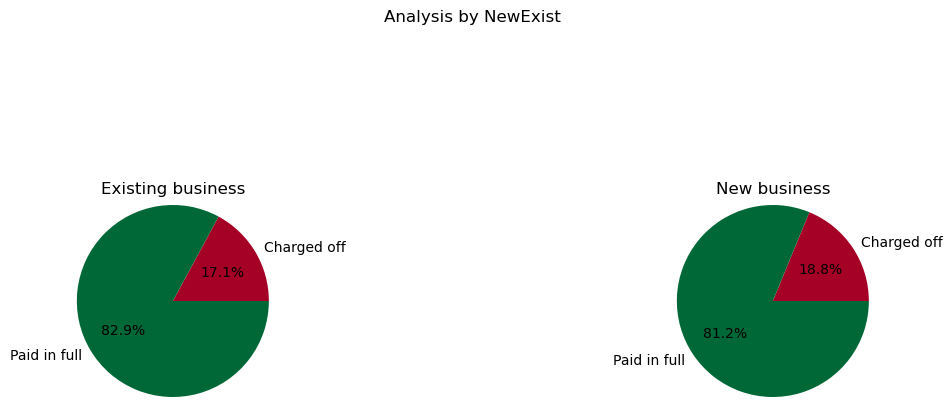

In [129]:
# Visualising NewExist
binary_visualisation(new_exist)

In [130]:
# We can extract information on the industry of certain businesses using the first two
# digits of the NAICS codes. The correspondence is shown in the dictionary below:
naics_df = pd.read_csv('NAICS_codes.csv')
naics_df.set_index('2 digit code', inplace=True)
naics_dict = naics_df['Description'].to_dict()
print(naics_dict)

{'21': 'Mining, quarrying, and oil and gas extraction', '11': 'Agriculture, forestry, fishing and hunting', '55': 'Management of companies and enterprises', '62': 'Health care and social assistance', '22': 'Utilities', '92': 'Public administration', '54': 'Professional, scientific, and technical services', '42': 'Wholesale trade', '31–33': 'Manufacturing', '81': 'Other services (except public administration)', '71': 'Arts, entertainment, and recreation', '72': 'Accommodation and food services', '44–45': 'Retail trade', '23': 'Construction', '56': 'Administrative/support & waste management/remediation Service', '61': 'Educational services', '51': 'Information', '48–49': 'Transportation and warehousing', '52': 'Finance and insurance', '53': 'Real estate and rental and leasing'}


In [131]:
# Some keys have hyphens in them; let's extract them
print([(k, v) for k, v in naics_dict.items() if '–' in k])
# We will account for this later

[('31–33', 'Manufacturing'), ('44–45', 'Retail trade'), ('48–49', 'Transportation and warehousing')]


In [132]:
# Adding an item to the dictionary to account for unknowns
naics_dict['0'] = 'Unknown'

In [133]:
# We create two new columns, 'Industry' and 'IndustryCode',
# from the NAICS column using this dictionary
df['Industry'] = df['NAICS'].astype(str)
df['Industry'] = df['Industry'].str[:2]
df['IndustryCode'] = df.Industry.astype(int)
# Applying function to Industry to account for the hyphens in the dictionary
df.Industry = df.Industry.apply(lambda x: '31–33' if x in ['31', '32', '33']
                                else ('44–45' if x in ['44', '45'] else ('48–49' if x in ['48', '49'] else x)))
df.Industry = df.Industry.replace(naics_dict)

In [134]:
# Conducting industrial analysis
by_industry = default_rate_calc('Industry')
by_industry.insert(1, 'IndustryCode', 
                   by_industry.Industry.map({v: k for k, v in naics_dict.items()}))
print(by_industry)  
# Definite correlation here.

                                             Industry IndustryCode  Num_Loans  \
15                 Real estate and rental and leasing           53      13581   
6                               Finance and insurance           52       9460   
17                     Transportation and warehousing        48–49      22396   
8                                         Information           51      11349   
5                                Educational services           61       6393   
1   Administrative/support & waste management/reme...           56      32495   
4                                        Construction           23      66421   
16                                       Retail trade        44–45     126851   
0                     Accommodation and food services           72      67384   
3                 Arts, entertainment, and recreation           71      14592   
12      Other services (except public administration)           81      72315   
20                          

In [135]:
# To conduct analysis on continuous features (DisbursementGross, SBA_Appv, Gr_Appv) we need to modify our
# default rate function so that it divides the data into bins. Below, quants refers to quantiles.
def default_rate_calc_with_cut(colname, quants):
    # Creating a dataframe showing number of loans per group
    bins = df[colname].quantile(quants, interpolation='nearest')
    b = pd.cut(df[colname], bins=bins, include_lowest=True, duplicates='drop')
    final_df = df.groupby(pd.cut(df[colname], bins, duplicates='drop')).LoanNr_ChkDgt.count().reset_index()
    final_df.rename(columns={'LoanNr_ChkDgt': 'Num_Loans'}, inplace=True)

    # Creating a dataframe showing MIS_Status per group
    mis = df.groupby([b, 'MIS_Status']).LoanNr_ChkDgt.count().unstack(fill_value=0).stack().reset_index()
    mis.columns = [colname, 'MIS_Status', 'Count']

    # Calculating default rate
    ls = []
    for j in range(int(len(mis.Count) / 2)):
        numerator = mis.Count[2 * j]
        denominator = numerator + mis.Count[2 * j + 1]

        if denominator == 0:
            ls.append(float(0))
        else:
            ls.append(100 * round(numerator / denominator, 3))

    # Adding default rates to initial dataframe
    final_df['Default_Rate_Pct'] = ls
    final_df.sort_values(by='Default_Rate_Pct', ascending=False, inplace=True)
    return final_df

In [136]:
# Disbursement gross analysis
quantiles = [0, 0.25, 0.5, 0.75, 1]
dis_gross = default_rate_calc_with_cut('DisbursementGross', quantiles)
print(dis_gross)  
# There is strong correlation here

        DisbursementGross  Num_Loans  Default_Rate_Pct
0       (4000.0, 42399.0]     223876              24.7
1     (42399.0, 100000.0]     252458              19.9
2    (100000.0, 238300.0]     195547              15.4
3  (238300.0, 11446325.0]     223998               9.8


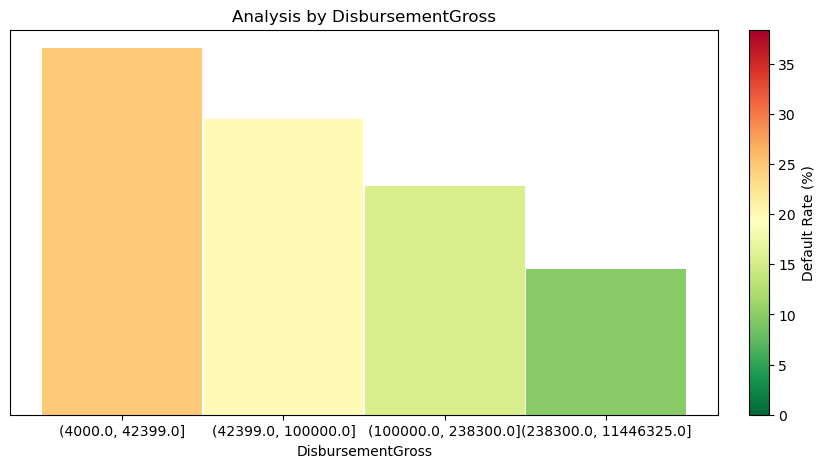

In [137]:
# Visualising dis_gross:
quartile_visualisation(dis_gross)

In [138]:
# SBA Approval analysis (SBA's guaranteed amount of approved loan)
sba_approval = default_rate_calc_with_cut('SBA_Appv', quantiles)
print(sba_approval)  
# There is strong correlation here

                SBA_Appv  Num_Loans  Default_Rate_Pct
0       (500.0, 21250.0]     226024              29.1
1     (21250.0, 61991.0]     221925              20.9
2    (61991.0, 175000.0]     225761              11.3
3  (175000.0, 5472000.0]     222240               8.9


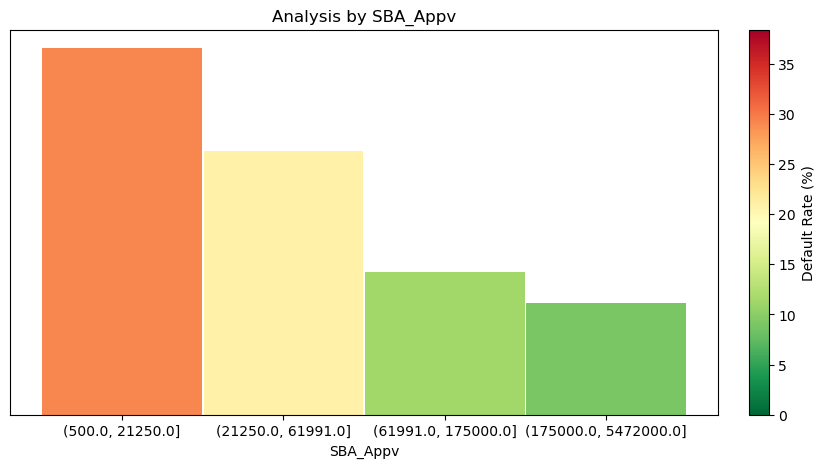

In [139]:
# Visualising SBA_Appv:
quartile_visualisation(sba_approval)

In [140]:
# Analysis by gross amount of loan approved by bank
gr_approval = default_rate_calc_with_cut('GrAppv', quantiles)
print(gr_approval)  
# There is strong correlation here

                  GrAppv  Num_Loans  Default_Rate_Pct
0      (1000.0, 35000.0]     237381              27.9
1     (35000.0, 90000.0]     212126              19.2
2    (90000.0, 225000.0]     222743              13.3
3  (225000.0, 5472000.0]     223700               9.3


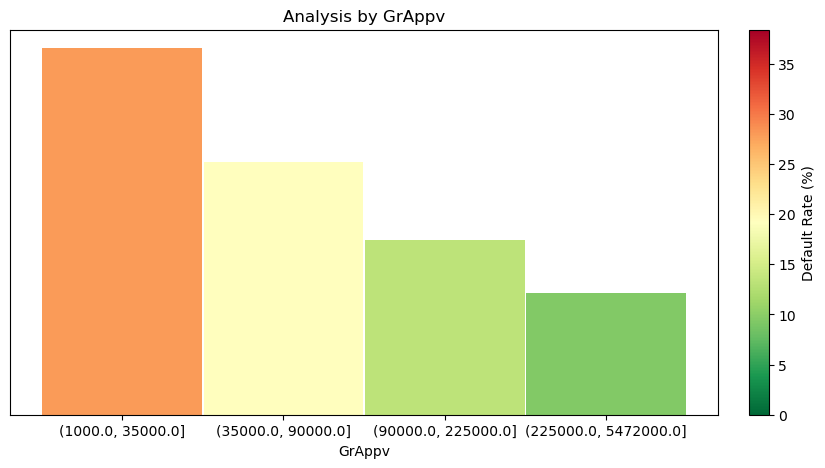

In [141]:
# Visualising GrAppv:
quartile_visualisation(gr_approval)

In [142]:
# We now combine the above two features by examining SBA's guaranteed portion of approved loan
df['Portion'] = df.apply(lambda row: row['SBA_Appv'] / row['GrAppv'], axis=1)
portion = default_rate_calc_with_cut('Portion', quantiles)
print(portion)  
# Strong correlation

         Portion  Num_Loans  Default_Rate_Pct
0  (0.0281, 0.5]     326717              26.4
2   (0.75, 0.85]     218275              17.1
1    (0.5, 0.75]     197021              12.2
3    (0.85, 1.0]     153991               6.5


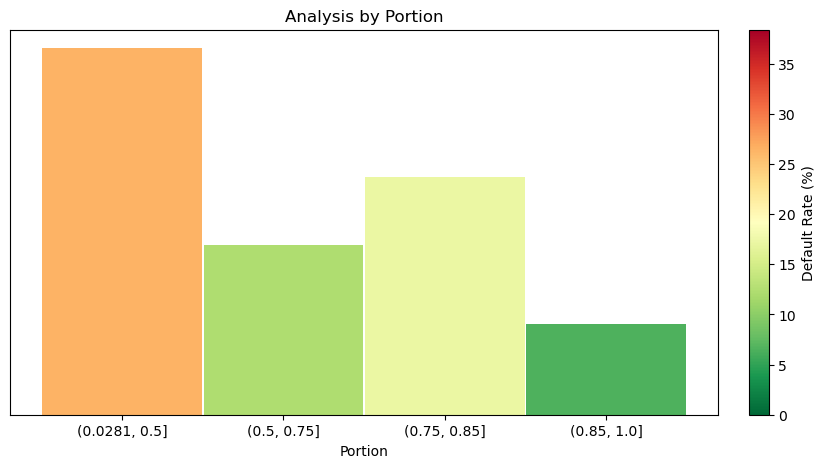

In [143]:
quartile_visualisation(portion)

In [144]:
# Analysis by number of employees
emp_quantiles = [0, 0.5, 1]
no_emp = default_rate_calc_with_cut('NoEmp', emp_quantiles)
print(no_emp)  
# Although there is some correlation, the datapoint may be unreliable, 
# due to the high proportion of zeros which could correspond to unknowns.

       NoEmp  Num_Loans  Default_Rate_Pct
0     (0, 4]     455025              21.2
1  (4, 9999]     434370              13.7


In [145]:
# Analysis by jobs created/retained
job_cre = default_rate_calc_with_cut('CreateJob', emp_quantiles)
print(job_cre)  
# Similar to above; more than 50% of datapoints are zero

job_ret = default_rate_calc_with_cut('RetainedJob', emp_quantiles)
print(job_ret)  # Similar to NoEmp


   CreateJob  Num_Loans  Default_Rate_Pct
0  (0, 8800]     269297              17.6
  RetainedJob  Num_Loans  Default_Rate_Pct
1   (1, 9500]     368688              24.1
0      (0, 1]      88238              13.0


In [146]:
# Loan term analysis
by_term = default_rate_calc_with_cut('Term', quantiles)
print(by_term)
# Good correlation; below we investigate further. However, note that a large portion of loans (73%)
# have terms >= 5 years. As the dataset is from 2015, a large portion of loan data from here will be unreliable,
# as the loan is likely still ongoing. Thus, we restrict the dataset for loans starting in 2011 or before.
df = df[df.DisbursementDate < np.datetime64('2011-01-01')]


         Term  Num_Loans  Default_Rate_Pct
0     (0, 60]     264544              38.4
2   (84, 120]     125913              11.4
1    (60, 84]     290305              10.9
3  (120, 569]     214438               4.5


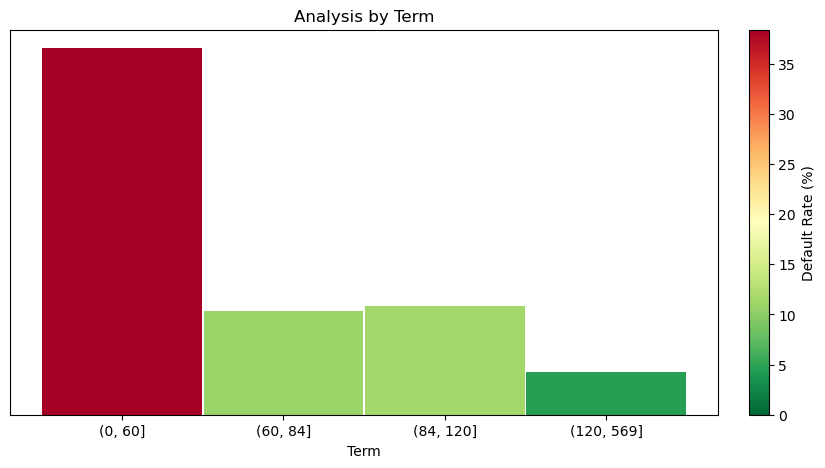

In [147]:
# Visualising Term
quartile_visualisation(by_term)

In [148]:
# Loans with terms > 240 months will be backed by real state, as loan term is a function
# of the expected lifetime of the asset. Creating a column to quantify this:
df['RealEstate'] = df.Term.apply(lambda term: 1 if term >= 240 else 0)

In [149]:
# Carrying out analysis
by_real_estate = default_rate_calc('RealEstate')
by_real_estate.RealEstate = by_real_estate.RealEstate.map({1: 'Backed by real estate', 0: 'Not backed by real estate'})
print(by_real_estate)  
# Clear correlation here

                  RealEstate  Num_Loans  Default_Rate_Pct
0  Not backed by real estate     724111              21.2
1      Backed by real estate     149946               1.6


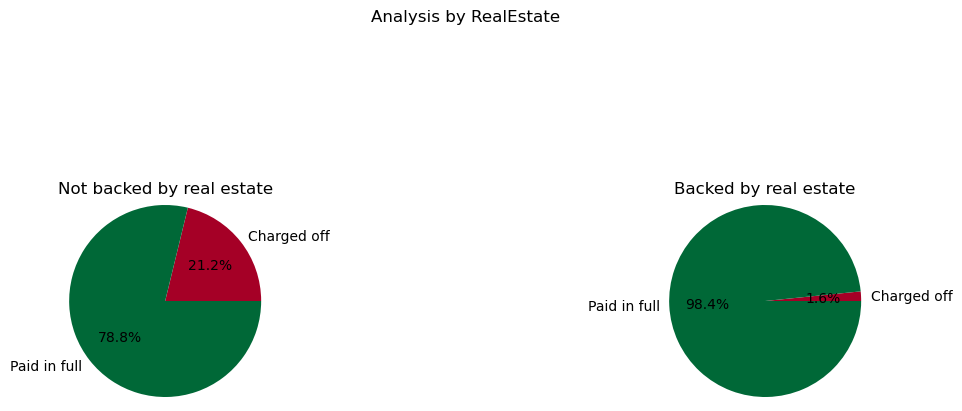

In [150]:
# Visualising RealEstate
binary_visualisation(by_real_estate)

In [151]:
# Investigating loans that end during the recession.
# Creating 'End of Loan' column, = disbursement date + loan term
print(df.DisbursementDate.head())
df['LoanEnd'] = df.apply(lambda row: row['DisbursementDate'] 
                         + np.timedelta64(row['Term'], 'M'), axis=1)
df.LoanEnd = df.LoanEnd.dt.normalize()
print(df.Term.head())
print(df.LoanEnd.head())

0   1999-02-28
1   1997-05-31
2   1997-12-31
3   1997-06-30
4   1997-05-14
Name: DisbursementDate, dtype: datetime64[ns]
0     84
1     60
2    180
3     60
4    240
Name: Term, dtype: int64
0   2006-02-27
1   2002-05-31
2   2012-12-30
3   2002-06-30
4   2017-05-13
Name: LoanEnd, dtype: datetime64[ns]


In [152]:
# Creating a recession column: 1 if loan ends during recession, 0 if not
recession_start, recession_end = np.datetime64('2007-12-01'), np.datetime64('2009-06-30')
recess = pd.date_range(recession_start, recession_end)
df['Recession'] = df.apply(lambda row: 1 if row.LoanEnd in recess else 0, axis=1)

In [153]:
# Recession-based analysis
by_recession = default_rate_calc('Recession')
by_recession.Recession = by_recession.Recession.map(
    {1: 'Loan ends during the recession', 0: 'Loan does not end during the recession'})
print(by_recession)  
# There is strong correlation here.

                                Recession  Num_Loans  Default_Rate_Pct
1          Loan ends during the recession      70542              31.3
0  Loan does not end during the recession     803515              16.6


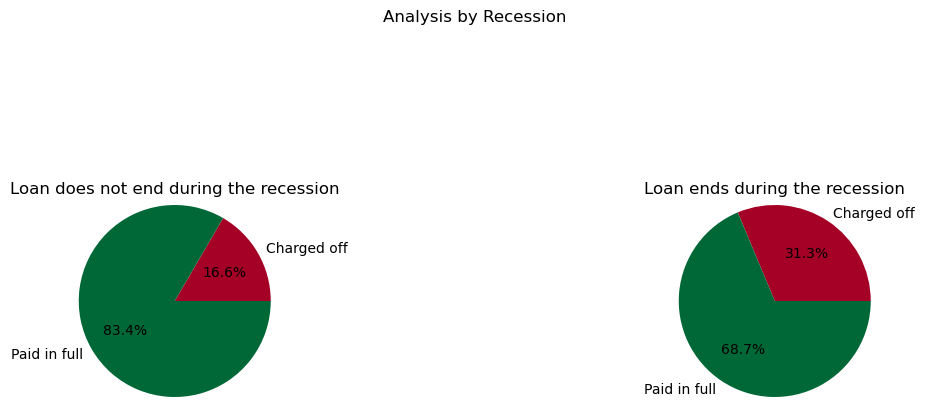

In [154]:
# Visualising by_recession:
binary_visualisation(by_recession)

In [155]:
# Creating extra column for logistic regression: 
# Default: 1 if MIS_Status = CHGOFF, 0 if MIS_Status = PIF
df['Default'] = df.MIS_Status.apply(lambda p: 1 if p == 'CHGOFF' else 0).astype(int)

In [157]:
# Finally, we export the main dataframe, which is now ready for regression.
"""df.to_csv('SBANational_regr.csv', index=False)"""